## Homework 2: Wine Quality Prediction Using SGD
### Student Name: First Last
### Department:
### Course: CS 474/574: Deep Learning/2020 Fall
### Due: 09/25/2020


Description: In this homework, you are going to implement the stochastic gradient optimization (mini-batch) to solve the wine quality prediction problem. Using the following code as your template. Specific requirements:

1. Use the SGD function definition given in the code (def SGD(X, Y, lr = 0.001, batch_size = 32, epoch = 100):); and do not change it.

2. SGD implementation. 35 pts
    - Shuffle data (X and Y) at the beginning of each epoch. (10 pts)
    - update w using minibatches correctly. (10 pts)
    - record the loss and w at the end of each epoch. (10 pts)
    - Decay learning rate at the end of each epoch. (5 points)
    
3. Evaluation (cross-validation). 65 pts
    - Split the dataset into training (70%) and test (30%) sets. (10 points)
    - Calculate and print out the MSE and MAE of GD for the training and test sets, respectively. (20 points)
        - Print formate: 
            The training MSE is: , the traing MAE is: .
            The test MSE is: , the test MAE is: .               
    - Calculate and print out the MSE and MAE of SGD for the training and test sets, respectively. (20 points)
         - Print formate: 
            The training MSE is: , the traing MAE is: .
            The test MSE is: , the test MAE is: . 
            
    - Plot the loss curve for SGD. (5 points)
        - tip: using the 'plot' function in matplotlib
        
    - Plot the mse curves on the training and test sets, respectively, over the weight sequence (w_hist). (10 points)

In [10]:
import pandas as pd
import numpy as np
import sklearn.metrics
from matplotlib import pyplot as plt

## (1) Data preparation
df=pd.read_csv('winequality-white.csv', sep = ';')
df
X = df.values[:, :11]
Y = df.values[:, 11]
print('Data shape:', 'X:', X.shape, 'Y:', Y.shape)

# data normalization
min_vals = np.min(X, axis = 0)
max_vals = np.max(X, axis = 0)
X1 = (X-min_vals)/(max_vals-min_vals)

##(2) Assume a linear mode that y = w0*1 + w_1*x_1 +w_2*x_2+...+ w_11*x_11
def predict(X, w):
    '''
    X: input feature vectors:m*n
    w: weights
    
    return Y_hat
    '''
    # Prediction
    Y_hat = np.zeros((X.shape[0]))
    for idx, x in enumerate(X):          
        y_hat = w[0] + np.dot(w[1:].T, np.c_[x]) # linear model
        Y_hat[idx] = y_hat    
    return Y_hat

## (3) Loss function: L = 1/2 * sum(y_hat_i - y_i)^2
def loss(w, X, Y):
    '''
    w: weights
    X: input feature vectors
    Y: targets
    '''
    Y_hat = predict(X, w)
    loss = 1/2* np.sum(np.square(Y - Y_hat))
    
    return loss

# Optimization 1: Gradient Descent
def GD(X, Y, lr = 0.001, delta = 0.01, max_iter = 100):
    '''
    X: training data
    Y: training target
    lr: learning rate
    max_iter: the max iterations
    '''
    
    m = len(Y)
    b = np.reshape(Y, [Y.shape[0],1])
    w = np.random.rand(X.shape[1] + 1, 1)
    A = np.c_[np.ones((m, 1)), X]
    gradient = A.T.dot(np.dot(A, w)-b)
    
    loss_hist = np.zeros(max_iter) # history of loss
    w_hist = np.zeros((max_iter, w.shape[0])) # history of weight
    loss_w = 0
    i = 0                  
    while(np.linalg.norm(gradient) > delta) and (i < max_iter):
        w_hist[i,:] = w.T
        loss_w = loss(w, X, Y)
#         print(i, 'loss:', loss_w)
        loss_hist[i] = loss_w
        
        w = w - lr*gradient        
        gradient = A.T.dot(np.dot(A, w)-b) # update the gradient using new w
        i = i + 1
        
    w_star = w  
    return w_star, loss_hist, w_hist

Data shape: X: (4898, 11) Y: (4898,)


In [11]:
# Optimization 2: implement the minibatch Gradient Descent approach
def SGD(X, Y, lr = 0.001, batch_size = 32, epoch = 100):
    '''
    X: training data
    Y: training target
    lr: learning rate
    batch_size: batch size
    epoch: number of max epoches
    
    return: w_star, loss_hist, w_hist
    '''
    
    m = len(Y)
    w = np.random.rand(X.shape[1] + 1, 1)
    loss_hist = np.zeros(epoch) # loss history
    w_hist = np.zeros((epoch, w.shape[0])) #w history
    
    #Add your code here
    #------------------------
    decay = 0.9
    for i in range(epoch):
        #(2)shuffle the data and prepare batches
        '''
        shuffling training and target set accordingly
        '''
        prem = np.random.permutation(m)
        x_shuffle = X[prem]
        y_shuffle = Y[prem]
        for j in range(int(m/batch_size)):   # does not accout for last batch(fix later!!)
            # updating w using mini-batches
            x_batch = x_shuffle[j*batch_size : (j+1)*batch_size]
            y_batch = y_shuffle[j*batch_size : (j+1)*batch_size]
                                    
            '''
            Shapes of matrices:
            x_batch: 32x11, y_batch: 32, w: 12x1
            A: 32x12, b: 32x1
            '''
            
            b = np.reshape(y_batch, [y_batch.shape[0], 1]) # Reshapes into a 2d array
            A = np.c_[np.ones((batch_size, 1)), x_batch]  # concatenating (32x11) (32x1) ==> (32x12))
            
            # calculating gradient and updating w
            g = A.T.dot(np.dot(A, w)-b)
            w = w - lr*g
        
        w_hist[i,:] = w.T
        loss_hist[i] = loss(w, x_shuffle, y_shuffle)
        lr *= decay

    #--------------------------
    
    w_star = w  
    return w_star, loss_hist, w_hist

In [12]:
# Split the dataset into training (70%) and test (30%) sets. (10 points)
train_size = int(0.7*len(X1))
X_train, X_test = X1[:train_size, :], X1[train_size:, :]
Y_train, Y_test = Y[:train_size], Y[train_size:]

In [13]:
# Calculate and print out the MSE and MAE of GD for the training and test sets, respectively. (20 points)
w_star, loss_hist, w_hist = GD(X_train, Y_train, lr = 0.0001, delta = 0.01)

Y_train_hat = predict(X_train, w_star)
train_MSE = np.square(np.subtract(Y_train, Y_train_hat)).mean()
train_MAE = np.abs(np.subtract(Y_train, Y_train_hat)).mean()

Y_test_hat = predict(X_test, w_star)
test_MSE = np.square(np.subtract(Y_test, Y_test_hat)).mean()
test_MAE = np.abs(np.subtract(Y_test, Y_test_hat)).mean()
print('The training MSE is: ', train_MSE, ' The training MAE is: ', train_MAE, 'The test MSE is: ', test_MSE, ' The test MAE is: ', test_MAE)

# Calculate and print out the MSE and MAE of SGD for the training and test sets, respectively. (20 points)
w_star_sthc, loss_hist_sthc, w_hist_sthc = SGD(X_train, Y_train, lr = 0.001, batch_size = 32, epoch = 100)

Y_train_hat_sthc = predict(X_train, w_star_sthc)
train_MSE_sthc = np.square(np.subtract(Y_train, Y_train_hat_sthc)).mean()
train_MAE_sthc = np.abs(np.subtract(Y_train, Y_train_hat_sthc)).mean()

Y_test_hat_sthc = predict(X_test, w_star_sthc)
test_MSE_sthc = np.square(np.subtract(Y_test, Y_test_hat_sthc)).mean()
test_MAE_sthc = np.abs(np.subtract(Y_test, Y_test_hat_sthc)).mean()
print('The training stochastic MSE is: ', train_MSE_sthc, ' The training stochastic MAE is: ', train_MAE_sthc, 'The test stochastic MSE is: ', test_MSE_sthc, ' The test stochastic MAE is: ', test_MAE_sthc)

The training MSE is:  0.7071887313426913  The training MAE is:  0.6537219043219245 The test MSE is:  0.6548673877174344  The test MAE is:  0.6250557998450257
The training stochastic MSE is:  0.7028157938964132  The training stochastic MAE is:  0.6487007892152038 The test stochastic MSE is:  0.6601612133553423  The test stochastic MAE is:  0.6255712592130677


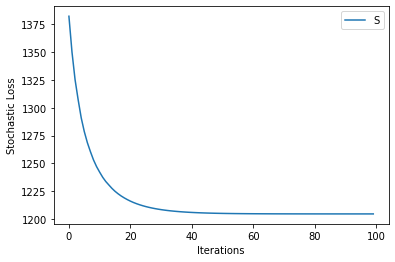

In [14]:
# Plot the loss curve for SGD. (5 points)
plt.plot(loss_hist_sthc)
plt.xlabel('Iterations')
plt.ylabel('Stochastic Loss')
plt.legend(('SGD'),loc='best')
plt.show()

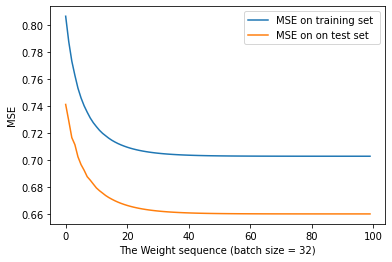

In [15]:
# Plot the mse curves on the training and test sets, respectively, over the weight sequence (w_hist). (10 points)
n_epochs = 100
MSE_SGD_train = np.zeros(n_epochs)
MSE_SGD_test = np.zeros(n_epochs)

for i in range(n_epochs):
    y_train_SGD_hat = predict(X_train, w_hist_sthc[i])
    y_test_SGD_hat = predict(X_test, w_hist_sthc[i])
    
    MSE_SGD_train[i] = np.square(np.subtract(Y_train, y_train_SGD_hat)).mean()
    MSE_SGD_test[i] = np.square(np.subtract(Y_test, y_test_SGD_hat)).mean()
    
plt.plot(range(n_epochs), MSE_SGD_train)
plt.plot(range(n_epochs), MSE_SGD_test)
plt.xlabel('The Weight sequence (batch size = 32)')
plt.ylabel('MSE')
plt.legend(('MSE on training set ', 'MSE on on test set '), loc='best') 
plt.show()